In [18]:
import numpy as np

import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense 
from keras.layers import Input, Dense
from keras import backend as K
from keras.models import load_model

##plot and visualize the data against time and observe how the feb 14-21 data is different from the rest of the data   

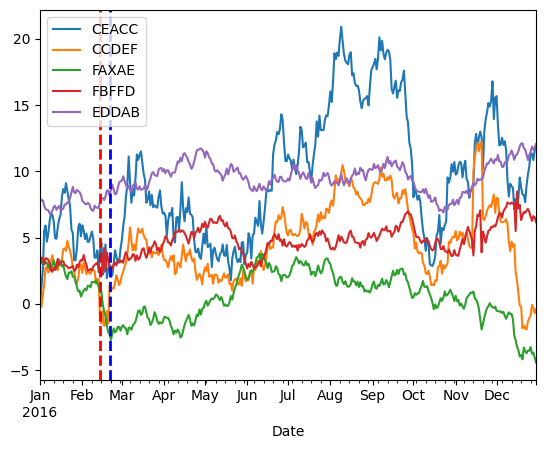

In [19]:
import matplotlib.pyplot as plt
df=pd.read_csv('anomaly_detection2.csv',parse_dates=['Date'])
# df_new=df.drop(['Date'],axis=1)
# df_new.plot()
df.set_index('Date',inplace=True)
df.plot()
plt.axvline(pd.to_datetime('2016-02-14'), color='r', linestyle='--', linewidth=2, label='Event 1')
plt.axvline(pd.to_datetime('2016-02-21'), color='b', linestyle='--', linewidth=2, label='Event 2')
plt.show()

In [20]:

import plotly.express as px
px.line(df,x=df.index,y=['CEACC', 'CCDEF', 'FAXAE', 'FBFFD', 'EDDAB'])


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=CEACC<br>Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'CEACC',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'CEACC',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0),
                          datetime.datetime(2016, 1, 2, 0, 0),
                          datetime.datetime(2016, 1, 3, 0, 0), ...,
                          datetime.datetime(2016, 12, 28, 0, 0),
                          datetime.datetime(2016, 12, 29, 0, 0),
                          datetime.datetime(2016, 12, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 0.        ,  1.23225977,  2.54012919, ..., 10.84136698, 11.58593208,
                          11.99195242]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=CCDEF<br>Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'CCDEF',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'CCDEF',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0),
                          datetime.datetime(2016, 1, 2, 0, 0),
                          datetime.datetime(2016, 1, 3, 0, 0), ...,
                          datetime.datetime(2016, 12, 28, 0, 0),
                          datetime.datetime(2016, 12, 29, 0, 0),
                          datetime.datetime(2016, 12, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 0.        , -0.21730517,  0.60670884, ..., -0.31712651, -0.71042634,
                          -0.39958795]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=FAXAE<br>Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'FAXAE',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'FAXAE',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0),
                          datetime.datetime(2016, 1, 2, 0, 0),
                          datetime.datetime(2016, 1, 3, 0, 0), ...,
                          datetime.datetime(2016, 12, 28, 0, 0),
                          datetime.datetime(2016, 12, 29, 0, 0),
                          datetime.datetime(2016, 12, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 3.        ,  3.19378003,  3.18095   , ..., -3.68039695, -4.04611568,
                          -4.43606537]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=FBFFD<br>Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'FBFFD',
              'line': {'color': '#ab63fa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'FBFFD',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2016, 1, 1, 0, 0),
                          datetime.datetime(2016, 1, 2, 0, 0),
                          datetime.datetime(2016, 1, 3, 0, 0), ...,
                          datetime.datetime(2016, 12, 28, 0, 0),
                          datetime.datetime(2016, 12, 29, 0, 0),
                          datetime.datetime(2016, 12, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([3.        , 3.48999178, 3.46481115, ..., 6.61749071, 6.51904081,
                          6.15513884]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=EDDAB<br>Date=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'EDDAB',
    

###Data splitting

In [54]:
##Training data is between (01/01/2016 to 09/30/2016) and test period: (10/01/2016 to 12/30/2016)
train_df = df.loc['2016-03-01':'2016-07-30']
val_df=df.loc['2016-08-01':'2016-09-30']
anom_test_df=df.loc['2016-02-10':'2016-02-26']
norm_test_df = df.loc['2016-01-01':'2016-01-30']
monitored_period_df=df.loc['2016-01-01':'2016-09-30']
train_df.head(5)

test_df=df.loc['2016-10-01':'2016-12-30']


In [22]:
##create sequences out of time series data
def create_seq_data(data,seq_len):
    seq_data=[]
    for i in range(len(data)-seq_len):
        seq_data.append(data[i:i+seq_len])
    return np.array(seq_data)

In [60]:
seq_len=3
X_train_orig=create_seq_data(train_df,seq_len)
X_val_orig=create_seq_data(val_df,seq_len)
X_norm_test_orig=create_seq_data(norm_test_df,seq_len)
X_anom_test_orig=create_seq_data(anom_test_df,seq_len)

X_test_orig=create_seq_data(test_df,seq_len)
X_monitored_period_orig=create_seq_data(monitored_period_df,seq_len)

X_train=X_train_orig.reshape(-1,seq_len,train_df.shape[1])
# X_train=np.delete(X_train,[0,1],2).astype(float)
X_val=X_val_orig.reshape(-1,seq_len,val_df.shape[1])
X_norm_test=X_norm_test_orig.reshape(-1,seq_len,norm_test_df.shape[1])
X_anom_test=X_anom_test_orig.reshape(-1,seq_len,anom_test_df.shape[1])
X_monitored_period=X_monitored_period_orig.reshape(-1,seq_len,monitored_period_df.shape[1])

print(X_train.shape,X_val.shape,X_norm_test.shape,X_anom_test.shape)
print(X_anom_test)

X_test=X_test.reshape(-1,seq_len,test_df.shape[1])

(149, 3, 5) (58, 3, 5) (27, 3, 5) (14, 3, 5)
[[[ 3.47375743  2.46131873  1.63080201  2.94813226  7.40664464]
  [ 3.50540838  1.51870379  1.77735609  3.01439663  7.26016159]
  [ 4.0316598   1.87873178  1.55120058  3.10151955  7.26017837]]

 [[ 3.50540838  1.51870379  1.77735609  3.01439663  7.26016159]
  [ 4.0316598   1.87873178  1.55120058  3.10151955  7.26017837]
  [ 2.39837124  1.86555262  1.31415201  2.70164389  7.22802034]]

 [[ 4.0316598   1.87873178  1.55120058  3.10151955  7.26017837]
  [ 2.39837124  1.86555262  1.31415201  2.70164389  7.22802034]
  [ 4.04372489 -1.21956506  0.90519526  2.28898941  7.7092109 ]]

 [[ 2.39837124  1.86555262  1.31415201  2.70164389  7.22802034]
  [ 4.04372489 -1.21956506  0.90519526  2.28898941  7.7092109 ]
  [ 4.57628224 -1.49207064  0.89978188  2.13057487  7.9684867 ]]

 [[ 4.04372489 -1.21956506  0.90519526  2.28898941  7.7092109 ]
  [ 4.57628224 -1.49207064  0.89978188  2.13057487  7.9684867 ]
  [ 2.21029403 -0.57662053 -0.04408993  3.03775938 

In [31]:
##retain the time stamps of vectors for future use
# X_train_dates=train_df.index[seq_len:]

# X_train_dates=pd.DataFrame({'Dates':train_df.index[seq_len:], 'CEACC':X_train_orig[:,0,0],'CCDEF':X_train_orig[:,0,1],'FAXAE':X_train_orig[:,0,2],'FBFFD':X_train_orig[:,0,3],'EDDAB':X_train_orig[:,0,4]})
# X_train_dates
X_anom_test_dates=pd.DataFrame({'Dates':anom_test_df.index[seq_len:], 'CEACC':X_anom_test_orig[:,0,0],'CCDEF':X_anom_test_orig[:,0,1],'FAXAE':X_anom_test_orig[:,0,2],'FBFFD':X_anom_test_orig[:,0,3],'EDDAB':X_anom_test_orig[:,0,4]}) 
X_anom_test_dates

,Dates,CEACC,CCDEF,FAXAE,FBFFD,EDDAB
0,2016-02-13,3.473757,2.461319,1.630802,2.948132,7.406645
1,2016-02-14,3.505408,1.518704,1.777356,3.014397,7.260162
2,2016-02-15,4.031660,1.878732,1.551201,3.101520,7.260178
3,2016-02-16,2.398371,1.865553,1.314152,2.701644,7.228020
4,2016-02-17,4.043725,-1.219565,0.905195,2.288989,7.709211
5,2016-02-18,4.576282,-1.492071,0.899782,2.130575,7.968487
6,2016-02-19,2.210294,-0.576621,-0.044090,3.037759,7.975463
7,2016-02-20,2.482837,-1.658767,-0.550546,4.215023,7.828515
8,2016-02-21,4.480263,-1.545013,-0.934196,2.485914,8.099992
9,2016-02-22,1.943677,-0.539503,-1.623672,3.877839,8.551997


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed,BatchNormalization,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import mean_squared_error





In [8]:
n_features=X_train.shape[2]
n_timesteps=X_train.shape[1]
batch_size=16
early_stopping=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
loss='mae'
metrics=['mae']
model=tf.keras.models.Sequential([
    layers.LSTM(8,return_sequences=True,input_shape=(seq_len,n_features)),
    # layers.LSTM(16,return_sequences=True),
    layers.LSTM(8,return_sequences=False,name="Latent"),
    RepeatVector(seq_len),
    #layers.LSTM(8,return_sequences=True),
    # layers.LSTM(16,return_sequences=True),
    layers.LSTM(8,return_sequences=True),
    layers.TimeDistributed(layers.Dense(n_features))
    ])
model.compile(optimizer='adam',loss=loss,metrics=metrics)
history=model.fit(X_train,X_train,epochs=100,batch_size=batch_size,validation_data=(X_val,X_val),shuffle=True,callbacks=[early_stopping])


Epoch 1/100


c:\Users\ccb\OneDrive\Desktop\Avatheon\v_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 5.6095 - mae: 5.6095 - val_loss: 8.5362 - val_mae: 8.5362
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4565 - mae: 5.4565 - val_loss: 8.5122 - val_mae: 8.5122
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5257 - mae: 5.5257 - val_loss: 8.4824 - val_mae: 8.4824
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4885 - mae: 5.4885 - val_loss: 8.4393 - val_mae: 8.4393
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4333 - mae: 5.4333 - val_loss: 8.3673 - val_mae: 8.3673
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3083 - mae: 5.3083 - val_loss: 8.2391 - val_mae: 8.2391
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2396 - mae: 5.2396 - val_loss: 8.0343 - val_mae: 8.0343
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9423 - mae: 4.9423 - val_loss: 7.7987 - val_mae: 7.7987
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9454 -

[5.5100226402282715, 5.490663051605225, 5.465813159942627, 5.431900501251221, 5.383427619934082, 5.305954933166504, 5.189844131469727, 5.034998416900635, 4.865238666534424, 4.686106204986572, 4.507335186004639, 4.334929466247559, 4.166398048400879, 4.006773948669434, 3.855760097503662, 3.715202569961548, 3.5874598026275635, 3.4716219902038574, 3.366020679473877, 3.271183967590332, 3.1841704845428467, 3.106342077255249, 3.032592296600342, 2.965791940689087, 2.9028849601745605, 2.8442986011505127, 2.788912773132324, 2.737041473388672, 2.6896278858184814, 2.644015073776245, 2.602374792098999, 2.5623703002929688, 2.5244452953338623, 2.488497257232666, 2.454131841659546, 2.422182321548462, 2.390242099761963, 2.3606040477752686, 2.331003189086914, 2.302807331085205, 2.2744431495666504, 2.246838092803955, 2.2196507453918457, 2.192582607269287, 2.166867971420288, 2.140632390975952, 2.1145646572113037, 2.0898633003234863, 2.065106153488159, 2.041309118270874, 2.018369436264038, 1.99486160278320

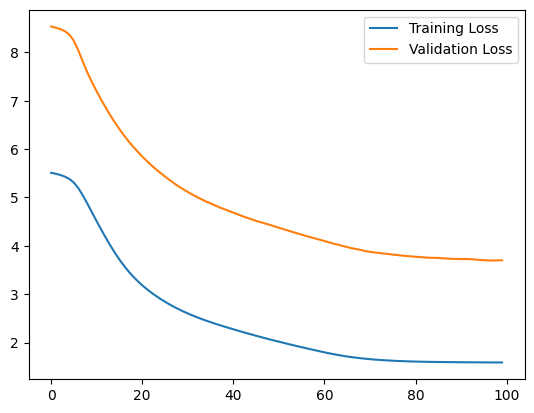

In [9]:
print(history.history["loss"])
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()

In [10]:
recons_good_test_data=model.predict(X_norm_test)
norm_test_data_loss=tf.keras.losses.mae(recons_good_test_data,X_norm_test)

recons_anom_test_data=model.predict(X_anom_test)
anom_test_data_loss=tf.keras.losses.mae(recons_anom_test_data,X_anom_test)

norm_test_data_loss_mean=np.mean(norm_test_data_loss,axis=1)
anom_test_data_loss_mean=np.mean(anom_test_data_loss,axis=1)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


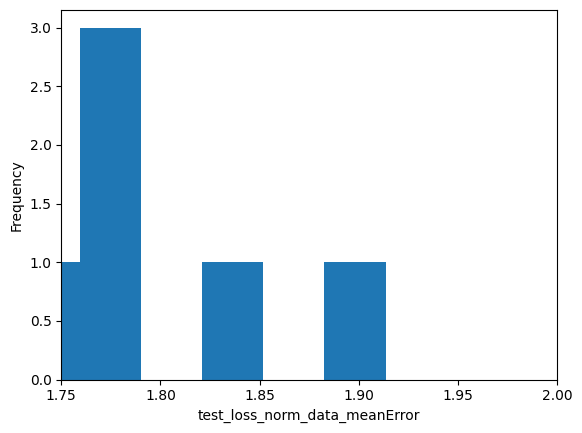

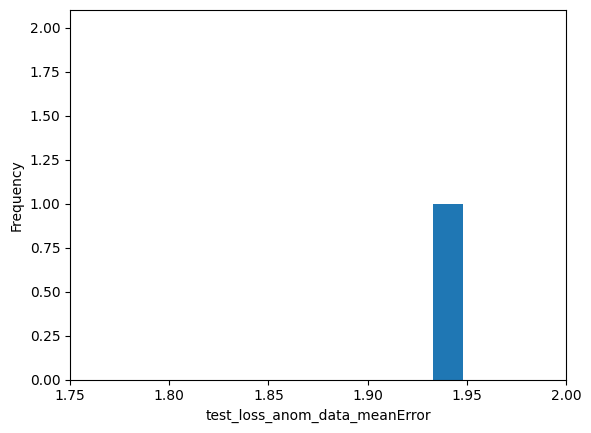

In [11]:
test_loss_norm_data_mean=np.mean(norm_test_data_loss,axis=1)
test_loss_anom_data_mean=np.mean(anom_test_data_loss,axis=1)

plt.hist(test_loss_norm_data_mean,bins=50)
plt.xlabel("test_loss_norm_data_meanError")
plt.ylabel("Frequency")
plt.xlim(1.75,2)
plt.show()


plt.hist(test_loss_anom_data_mean,bins=50)
plt.xlabel("test_loss_anom_data_meanError")
plt.ylabel("Frequency")
plt.xlim(1.75,2)
plt.show()

In [51]:
## predict the metrics for test data

# def predict(model,data,threshold):
recons_test_data=model.predict(X_test)
# print(X_test.shape)
data_loss_test=tf.keras.losses.mae(recons_test_data,X_test)
# print(data_loss)
data_loss_test_mean=tf.reduce_mean(data_loss_test,axis=1)
# print(data_loss_test_mean)
results_dated=pd.DataFrame({'Dates':test_df.index[seq_len:],'Loss':data_loss_test_mean})
display(results_dated)

##Normal plot
# results_dated.plot(x='Dates',y='Loss',figsize=(10,5))
# plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')

####potly plots for interactivity

fig = px.line(results_dated, x='Dates', y='Loss', title='Loss vs. Dates', labels={'Loss': 'Loss', 'Dates': 'Dates'}) 
# Add a threshold line threshold = 0.5 # Replace with the actual threshold value
fig.add_hline(y=threshold, line=dict(color='red', width=2, dash='dash'), annotation_text='Threshold', annotation_position='top left') # Customize the layout 
fig.update_layout( xaxis_title='Dates', yaxis_title='Loss', legend_title='Legend', template='plotly_white') # Show the plot 




    # # anomalous_data_indices=np.where(data_loss_mean>threshold)
    # return tf.math.less(threshold,data_loss_mean)
# def print_stats(predcitions,labels):
#     print("Accuracy={} ".format(accuracy_score(labels,predictions)))
#     print("Precision={} ".format(precision_score(labels,predictions)))
#     print("Recall={} ".format(recall_score(labels,predictions)))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,Dates,Loss
0,2016-10-04,1.004185
1,2016-10-05,0.855779
2,2016-10-06,0.767023
3,2016-10-07,0.715052
4,2016-10-08,0.814014
...,...,...
83,2016-12-26,3.226796
84,2016-12-27,3.272858
85,2016-12-28,3.315790
86,2016-12-29,3.314153


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Dates=%{x}<br>Loss=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2016, 10, 4, 0, 0),
                          datetime.datetime(2016, 10, 5, 0, 0),
                          datetime.datetime(2016, 10, 6, 0, 0),
                          datetime.datetime(2016, 10, 7, 0, 0),
                          datetime.datetime(2016, 10, 8, 0, 0),
                          datetime.datetime(2016, 10, 9, 0, 0),
                          datetime.datetime(2016, 10, 10, 0, 0),
                          datetime.datetime(2016, 10, 11, 0, 0),
                          datetime.datetime(2016, 10, 12, 0, 0),
                          datetime.datetime(2016, 10, 13, 0, 0),
                          datetime.datetime(2016, 10, 14, 0, 0),
                          datetime.datetime(2016, 10, 15, 0, 0),
                          datetime.datetime(2016, 10, 16, 0, 0),
                          datetime.datetime(2016, 10, 17, 0, 0),
                          datetime.datetime(2016, 10, 18, 0, 0),
                          datetime.datetime(2016, 10, 19, 0, 0),
                          datetime.datetime(2016, 10, 20, 0, 0),
                          datetime.datetime(2016, 10, 21, 0, 0),
                          datetime.datetime(2016, 10, 22, 0, 0),
                          datetime.datetime(2016, 10, 23, 0, 0),
                          datetime.datetime(2016, 10, 24, 0, 0),
                          datetime.datetime(2016, 10, 25, 0, 0),
                          datetime.datetime(2016, 10, 26, 0, 0),
                          datetime.datetime(2016, 10, 27, 0, 0),
                          datetime.datetime(2016, 10, 28, 0, 0),
                          datetime.datetime(2016, 10, 29, 0, 0),
                          datetime.datetime(2016, 10, 30, 0, 0),
                          datetime.datetime(2016, 10, 31, 0, 0),
                          datetime.datetime(2016, 11, 1, 0, 0),
                          datetime.datetime(2016, 11, 2, 0, 0),
                          datetime.datetime(2016, 11, 3, 0, 0),
                          datetime.datetime(2016, 11, 4, 0, 0),
                          datetime.datetime(2016, 11, 5, 0, 0),
                          datetime.datetime(2016, 11, 6, 0, 0),
                          datetime.datetime(2016, 11, 7, 0, 0),
                          datetime.datetime(2016, 11, 8, 0, 0),
                          datetime.datetime(2016, 11, 9, 0, 0),
                          datetime.datetime(2016, 11, 10, 0, 0),
                          datetime.datetime(2016, 11, 11, 0, 0),
                          datetime.datetime(2016, 11, 12, 0, 0),
                          datetime.datetime(2016, 11, 13, 0, 0),
                          datetime.datetime(2016, 11, 14, 0, 0),
                          datetime.datetime(2016, 11, 15, 0, 0),
                          datetime.datetime(2016, 11, 16, 0, 0),
                          datetime.datetime(2016, 11, 17, 0, 0),
                          datetime.datetime(2016, 11, 18, 0, 0),
                          datetime.datetime(2016, 11, 19, 0, 0),
                          datetime.datetime(2016, 11, 20, 0, 0),
                          datetime.datetime(2016, 11, 21, 0, 0),
                          datetime.datetime(2016, 11, 22, 0, 0),
                          datetime.datetime(2016, 11, 23, 0, 0),
                          datetime.datetime(2016, 11, 24, 0, 0),
                          datetime.datetime(2016, 11, 25, 0, 0),
                          datetime.datetime(2016, 11, 26, 0, 0),
                          datetime.datetime(2016, 11, 27, 0, 0),
                          datetime.datetime(2016, 11, 28, 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(271, 3, 5)
tf.Tensor(
[2.93025779 2.50028191 2.03123816 1.78819728 1.70694654 1.74514139
 1.60797429 1.55649551 1.62535867 1.780293   1.78264497 1.72119923
 1.62800936 1.50385535 1.4487953  1.43462096 1.4820386  1.54126439
 1.49761175 1.47354126 1.38961608 1.40603956 1.46149885 1.58489864
 1.82841029 1.89374414 1.6625483  1.33851322 1.12153421 1.10628185
 1.08263614 1.15705128 1.25241696 1.4500561  1.54869894 1.61598425
 1.61236608 1.62035671 1.70829713 1.87236556 1.93270462 2.0512845
 2.15817425 2.32042075 2.40205089 2.46049705 2.48377032 2.541886
 2.62375092 2.66070594 2.7036044  2.5224728  2.5201558  2.34627286
 2.16558766 2.02821157 2.00772835 1.97789875 1.85841367 1.59215584
 1.31226065 1.12773365 1.15643489 1.44393772 1.69850486 1.71317443
 1.43320363 1.18223273 1.23846222 1.46733028 1.73454443 1.8315212
 1.86103089 1.83345435 1.6312912  1.43705845 1.24788236 1.10362833
 0.95935188 0.9005472  0.9458188  0.84026432 0.77311171 0.7056806
 0.779

,Dates,Loss
0,2016-01-04,2.930258
1,2016-01-05,2.500282
2,2016-01-06,2.031238
3,2016-01-07,1.788197
4,2016-01-08,1.706947
...,...,...
266,2016-09-26,3.963309
267,2016-09-27,3.687733
268,2016-09-28,3.326128
269,2016-09-29,2.877319


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Dates=%{x}<br>Loss=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([datetime.datetime(2016, 1, 4, 0, 0),
                          datetime.datetime(2016, 1, 5, 0, 0),
                          datetime.datetime(2016, 1, 6, 0, 0), ...,
                          datetime.datetime(2016, 9, 28, 0, 0),
                          datetime.datetime(2016, 9, 29, 0, 0),
                          datetime.datetime(2016, 9, 30, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([2.93025779, 2.50028191, 2.03123816, ..., 3.3261282 , 2.87731897,
                          2.47654127]),
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'Threshold',
                                'x': 0,
                                'xanchor': 'left',
                                'xref': 'x domain',
                                'y': 1.9,
                                'yanchor': 'bottom',
                                'yref': 'y'}],
               'legend': {'title': {'text': 'Legend'}, 'tracegroupgap': 0},
               'shapes': [{'line': {'color': 'red', 'dash': 'dash', 'width': 2},
                           'type': 'line',
                           'x0': 0,
                           'x1': 1,
                           'xref': 'x domain',
                           'y0': 1.9,
                           'y1': 1.9,
                           'yref': 'y'}],
               'template': '...',
               'title': {'text': 'Loss vs. Dates'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Dates'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Loss'}}}
})

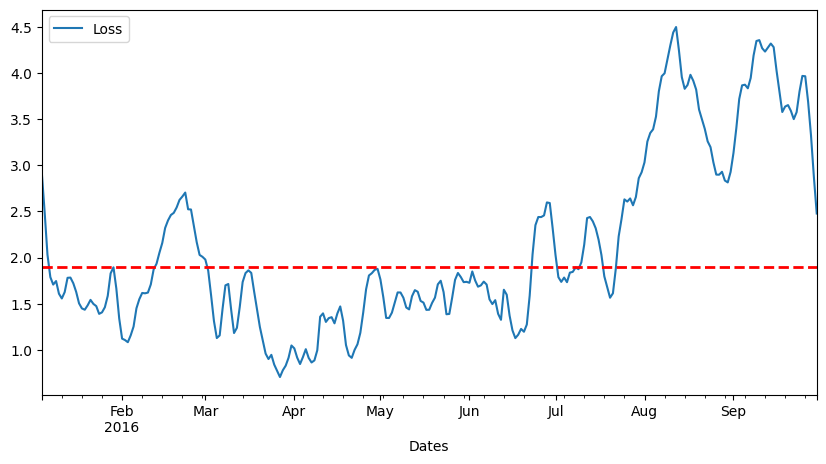

In [61]:
##plot the results for monitored period data to see number of anomalies and if the Feb 14 anaomaly is the only one being captured
recons_monitored_data=model.predict(X_monitored_period)
print(X_monitored_period.shape)
data_loss_monitored=tf.keras.losses.mae(recons_monitored_data,X_monitored_period)
# print(data_loss)
data_loss_monitored_mean=tf.reduce_mean(data_loss_monitored,axis=1)
print(data_loss_monitored_mean)
chk_monitored_data_dated=pd.DataFrame({'Dates':monitored_period_df.index[seq_len:],'Loss':data_loss_monitored_mean})
display(chk_monitored_data_dated)
chk_monitored_data_dated.plot(x='Dates',y='Loss',figsize=(10,5))
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')

###plot plotly plots for train data to analyze 

fig = px.line(chk_monitored_data_dated, x='Dates', y='Loss', title='Loss vs. Dates', labels={'Loss': 'Loss', 'Dates': 'Dates'}) # Add a threshold line threshold = 0.5 # Replace with the actual threshold value 
fig.add_hline(y=threshold, line=dict(color='red', width=2, dash='dash'), annotation_text='Threshold', annotation_position='top left') # Customize the layout
fig.update_layout( xaxis_title='Dates', yaxis_title='Loss', legend_title='Legend', template='plotly_white' ) # Show the plot fig.show()

In [34]:
##set the threshold for identifying anomalies based on MAE for normal and anomalous data
threshold=1.9
# anomalous_data_indices=np.where(test_loss_anom_data_mean>threshold)
# print(anomalous_data_indices)

In [35]:
preds=predict(model,X_test,threshold)
preds.dtype
num_true=tf.cast(tf.math.count_nonzero(preds),tf.int32)
num_false=tf.cast(tf.size(preds)-num_true,tf.int32)
print("Number of anomalies detected: ",num_true.numpy())

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
tf.Tensor(
[[1.63466244 0.74210288 0.63578905]
 [1.44172246 0.68092067 0.44469513]
 [1.27618327 0.48858263 0.53630287]
 [1.05534108 0.53309916 0.55671437]
 [1.07860605 0.50925241 0.85418335]
 [1.01094208 0.69166578 1.19168441]
 [0.77313182 1.02915295 1.3220708 ]
 [0.71194934 1.15952475 1.51668558]
 [0.70453267 1.39167401 1.45949331]
 [1.10858826 1.29691358 1.47664121]
 [0.83412382 1.31408158 1.86558605]
 [0.71450358 1.70299777 2.12235047]
 [1.02943544 1.95154734 2.21335387]
 [1.01880945 2.04253368 2.22784615]
 [1.02140012 2.05703775 1.83801481]
 [1.09220485 1.66721869 1.63157491]
 [0.97249675 1.49577859 1.38427049]
 [0.80118421 1.22655106 1.18248057]
 [0.53200877 1.01179463 1.54117261]
 [0.55661927 1.3704925  1.56463624]
 [0.52076016 1.39392216 1.39839421]
 [0.40930745 1.23471452 1.4585089 ]
 [0.40152055 1.29596212 1.32242186]
 [0.34653455 1.15987782 1.43875104]
 [0.2959887  1.37258003 1.23141386]
 [0.95296397 1.21359111 1.36584992]
 [1.20516906 1.

AttributeError: 'NoneType' object has no attribute 'dtype'

In [15]:
# import sklearn.metrics as metrics
# from sklearn.metrics import accuracy_score,precision_score,recall_score
# preds=predict(model,X_test,threshold)
# preds.dtype
# num_true=tf.cast(tf.math.count_nonzero(preds),tf.int32)
# num_